ENHANCED ALGORITHM COMPARISON VISUALIZATION SCRIPT

--- Step 1: File Upload ---
Please upload the 6 required Excel files one by one.

-> Uploading file for: Requirement-to-Test-Case Mapping (e.g., mapped_dataset_1.xlsx)


Saving mapped_dataset_1.xlsx to mapped_dataset_1 (1).xlsx
   Successfully uploaded 'mapped_dataset_1 (1).xlsx' for MAP.

-> Uploading file for: Random Algorithm Data (e.g., 248-80-random.xlsx)


Saving 124-40-random.xlsx to 124-40-random.xlsx
   Successfully uploaded '124-40-random.xlsx' for RAND.

-> Uploading file for: Greedy Algorithm Data (e.g., 248-80-greedy.xlsx)


Saving 124-40-greedy.xlsx to 124-40-greedy.xlsx
   Successfully uploaded '124-40-greedy.xlsx' for Greedy.

-> Uploading file for: BASELINE/BCPSO Data (e.g., 248-80-bcpso.xlsx)


Saving 124-40-bcpso.xlsx to 124-40-bcpso.xlsx
   Successfully uploaded '124-40-bcpso.xlsx' for BASELINE.

-> Uploading file for: RTS-GA Data (e.g., 248-80-rtsga.xlsx)


Saving 124-40-rtsga.xlsx to 124-40-rtsga.xlsx
   Successfully uploaded '124-40-rtsga.xlsx' for RTSGA.

-> Uploading file for: RTS-GA-HC Data (e.g., 240-80-rtsgahc.xlsx)


Saving 124-40-rtsgahc.xlsx to 124-40-rtsgahc.xlsx
   Successfully uploaded '124-40-rtsgahc.xlsx' for RTSGA-HC.

--- Step 2: Data Processing ---
-> Requirement map loaded. Average TCs per requirement: 0.32
-> Processing RAND...
-> Processing Greedy...
-> Processing BASELINE...
-> Processing RTSGA...
-> Processing RTSGA-HC...

All data processed and combined successfully.

--- Combined Performance Data Summary ---
    Time Budget (%)  Requirement Coverage (%)  Business Value    # Tests algorithm
0                 5                 19.731183      481.533333   7.892473      RAND
1                10                 33.252688      845.233333  13.301075      RAND
2                15                 46.801075     1119.000000  18.720430      RAND
3                20                 52.688172     1287.966667  21.075269      RAND
4                25                 42.930108     1062.533333  17.172043      RAND
5                30                 55.376344     1371.500000  22.150538      RAND
6  

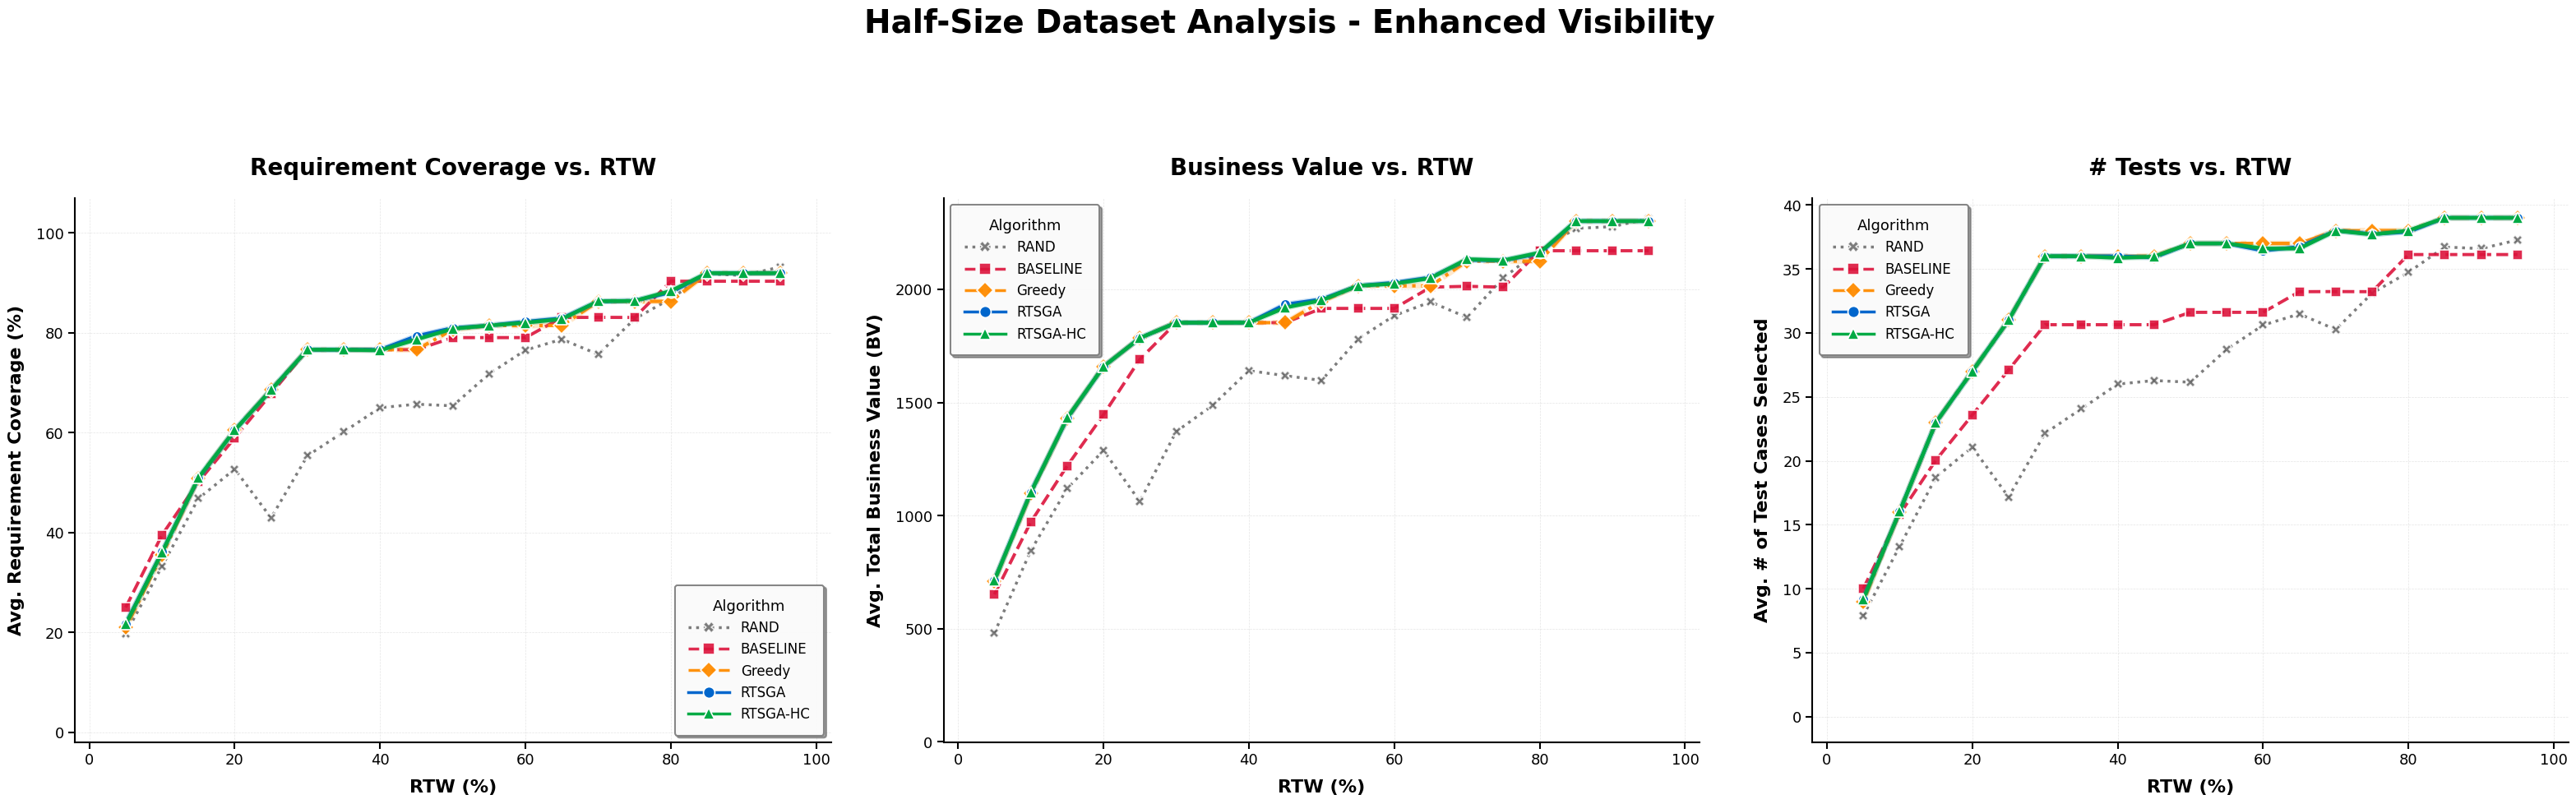

-> Enhanced combined plot saved as 'Enhanced_Combined_Comparison_Plot.png'

2. Generating enhanced individual plots...


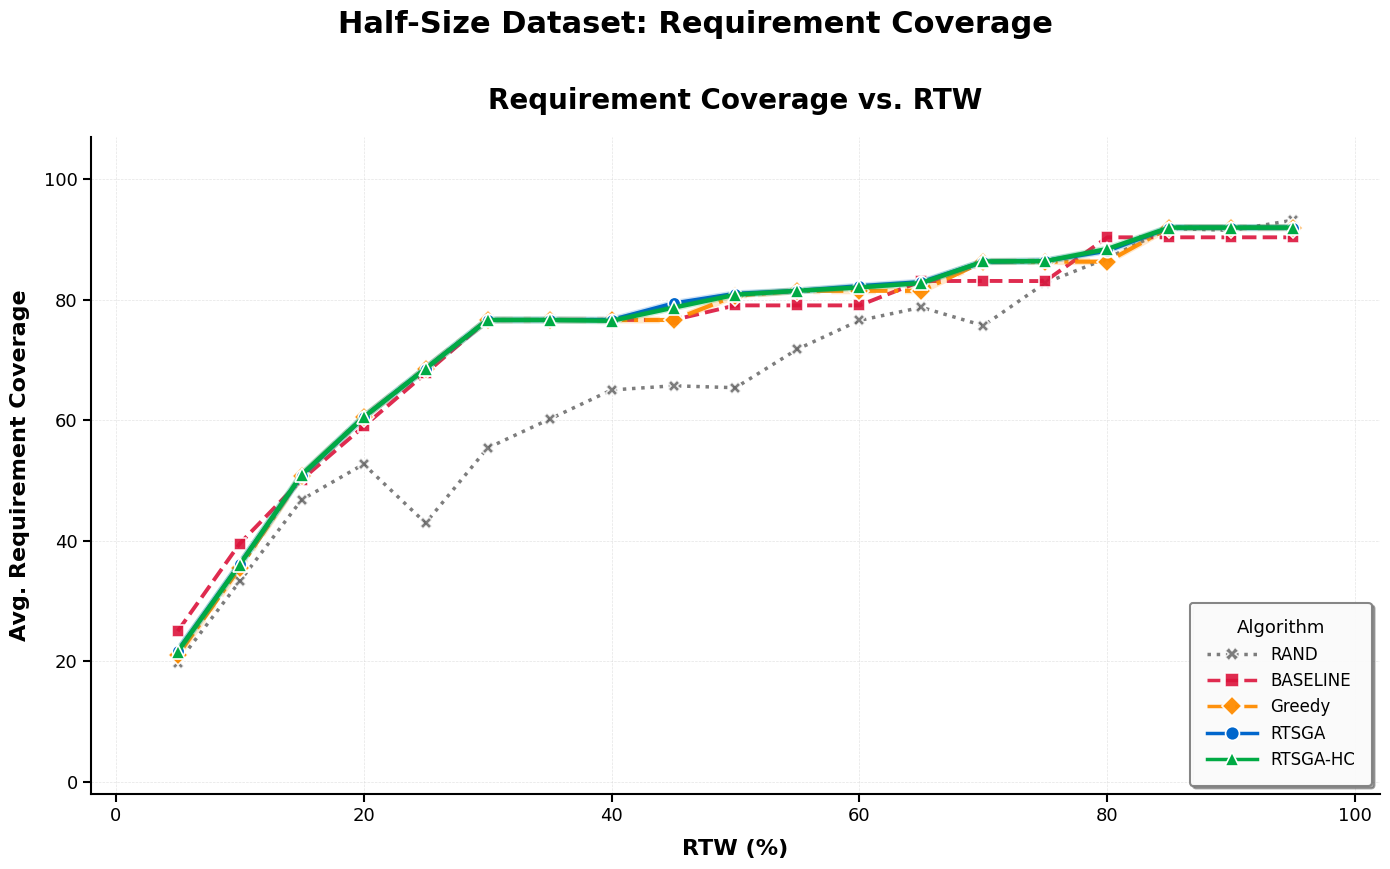

-> Enhanced individual plot saved as 'Enhanced_Requirement_Coverage_Plot.png'


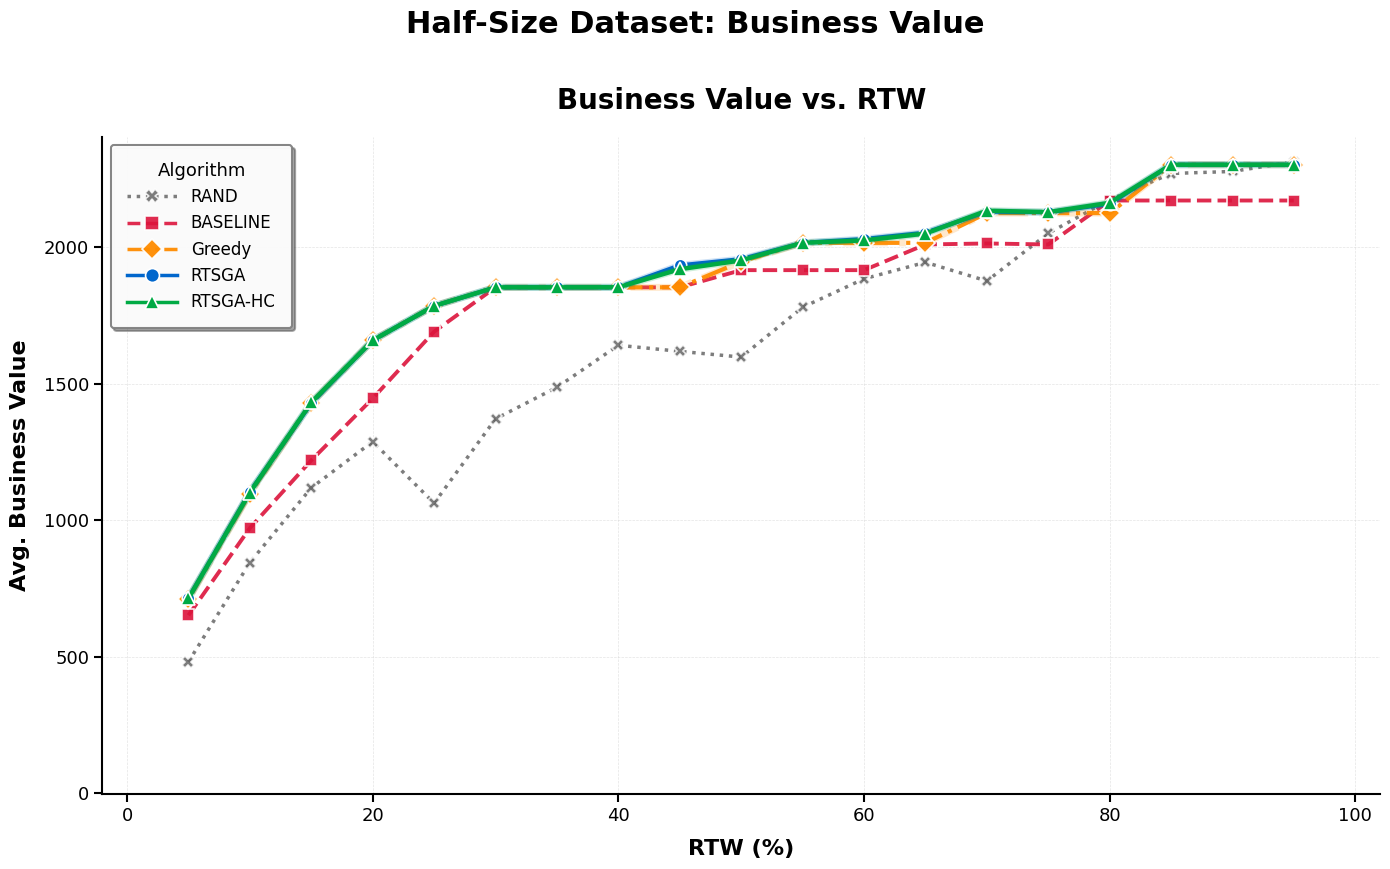

-> Enhanced individual plot saved as 'Enhanced_Business_Value_Plot.png'


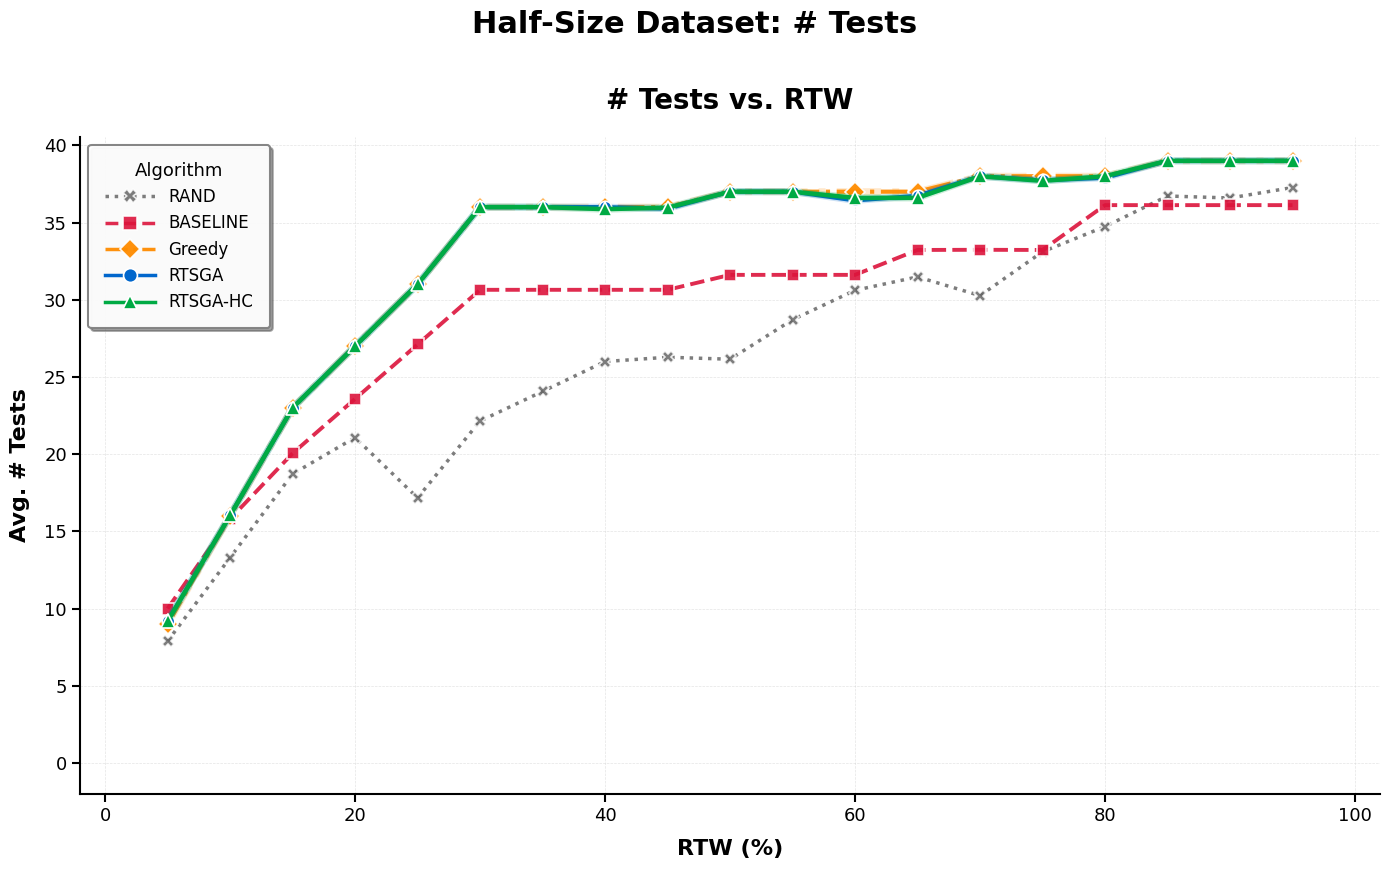

-> Enhanced individual plot saved as 'Enhanced_Num_Tests_Plot.png'

3. Generating algorithm performance comparison table...


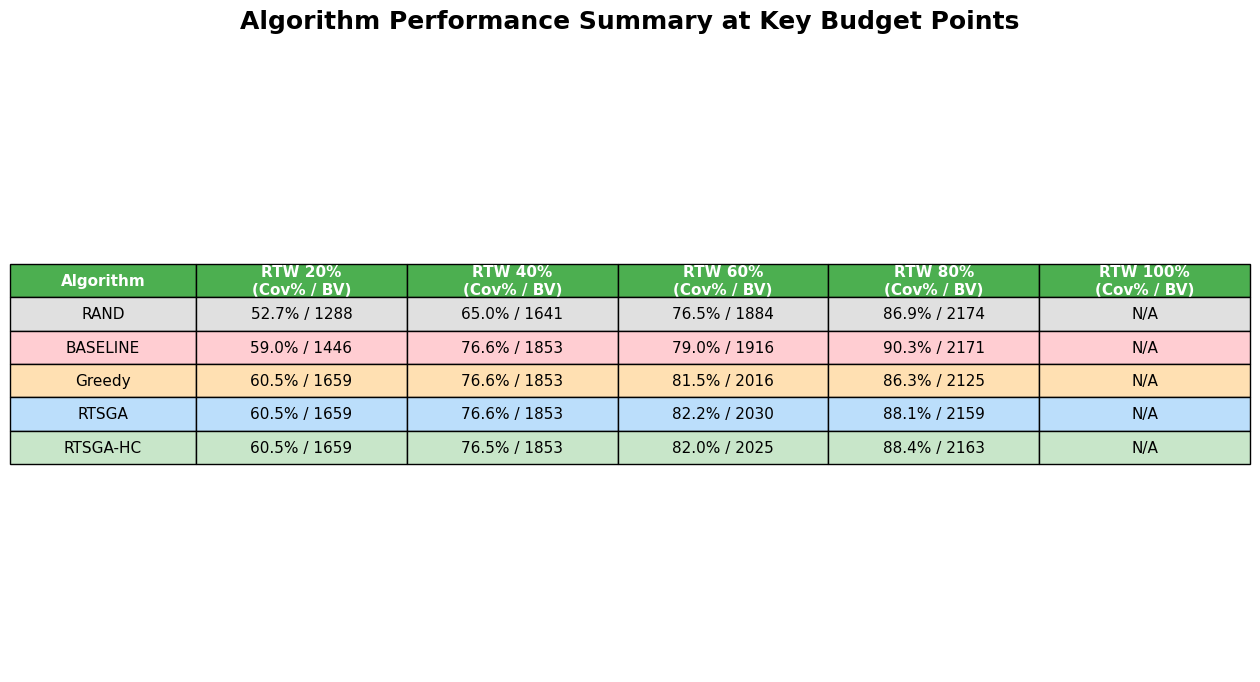

-> Performance table saved as 'Algorithm_Performance_Table.png'

--- ENHANCED VISUALIZATION SCRIPT COMPLETED SUCCESSFULLY ---
All plots have been generated with improved visibility and differentiation.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import ast
from google.colab import files

# ==============================================================================
# --- 1. CONFIGURATION ---
# ==============================================================================
# Modify these variables to switch between different datasets
TOTAL_REQUIREMENTS = 124
DATASET_NAME = "Half-Size Dataset"  # This name will appear in your plot titles

# ==============================================================================
# --- 2. HELPER & PROCESSING FUNCTIONS ---
# ==============================================================================

def get_test_count_from_reqs(req_list_str, lookup):
    """Safely calculates the number of unique test cases from a string representation of a requirement list."""
    try:
        req_list = ast.literal_eval(req_list_str)
        all_tcs = set()
        for req_id in req_list:
            if req_id in lookup:
                all_tcs.update(lookup[req_id])
        return len(all_tcs)
    except (ValueError, SyntaxError):
        return 0

def process_dataframe(df, algorithm_name, total_reqs, req_col, bv_col, test_col=None, tests_from_reqs_lookup=None, avg_tcs=0):
    """
    Standardizes a given dataframe into the format required for plotting and analysis.
    This function handles different column names and data structures.
    """
    if 'Time Budget %' in df.columns:
        df = df.rename(columns={'Time Budget %': 'budget_pct'})

    required_cols = [req_col, bv_col, 'budget_pct']
    for col in required_cols:
        if col not in df.columns:
            raise KeyError(f"Configuration Error: Column '{col}' not found for algorithm '{algorithm_name}'. Please check file_configs.")

    if df[req_col].max() > 100:
        df['coverage_pct'] = (df[req_col] / total_reqs) * 100
    else:
        df['coverage_pct'] = df[req_col]

    if test_col and test_col in df.columns:
        df['num_tests'] = df[test_col]
    elif tests_from_reqs_lookup and 'selected_reqs' in df.columns:
        df['num_tests'] = df['selected_reqs'].apply(lambda x: get_test_count_from_reqs(x, tests_from_reqs_lookup))
    else:
        df['num_tests'] = (df['coverage_pct'] / 100) * total_reqs * avg_tcs

    if 'run' in df.columns:
        summary = df.groupby('budget_pct').agg(
            coverage_pct=('coverage_pct', 'mean'),
            bv=(bv_col, 'mean'),
            num_tests=('num_tests', 'mean')
        ).reset_index()
    else:
        summary = df[['budget_pct', 'coverage_pct', bv_col, 'num_tests']].copy()
        summary.rename(columns={bv_col: 'bv'}, inplace=True)

    summary.rename(columns={
        'budget_pct': 'Time Budget (%)',
        'coverage_pct': 'Requirement Coverage (%)',
        'bv': 'Business Value',
        'num_tests': '# Tests'
    }, inplace=True)

    summary['algorithm'] = algorithm_name
    return summary

# ==============================================================================
# --- 3. ENHANCED PLOTTING FUNCTION WITH BETTER VISIBILITY ---
# ==============================================================================

def generate_plots(data, dataset_name):
    """Generates and saves a combined 1x3 plot and three individual plots with enhanced visibility and differentiation."""
    print("\n" + "=" * 70)
    print("--- Step 3: Generating Enhanced Plots ---")

    def plot_on_axis(ax, data, x_col, y_col, title, x_label, y_label, legend_loc='best'):
        # Enhanced styles with better differentiation
        styles = {
            'RAND': {
                'color': '#666666',  # Dark gray
                'marker': 'X',
                'markersize': 9,
                'linestyle': ':',
                'linewidth': 2.5,
                'label': 'RAND',
                'zorder': 1,
                'alpha': 0.85
            },
            'BASELINE': {
                'color': '#DC143C',  # Crimson red
                'marker': 's',
                'markersize': 8,
                'linestyle': '--',
                'linewidth': 2.8,
                'label': 'BASELINE',
                'zorder': 2,
                'alpha': 0.9
            },
            'Greedy': {
                'color': '#FF8C00',  # Dark orange
                'marker': 'D',
                'markersize': 10,
                'linestyle': '-.',
                'linewidth': 3,
                'label': 'Greedy',
                'zorder': 3,
                'alpha': 0.95
            },
            'RTSGA': {
                'color': '#0066CC',  # Deep blue
                'marker': 'o',
                'markersize': 9,
                'linestyle': '-',
                'linewidth': 3,
                'label': 'RTSGA',
                'zorder': 4,
                'alpha': 1.0
            },
            'RTSGA-HC': {
                'color': '#00AA44',  # Emerald green
                'marker': '^',
                'markersize': 10,
                'linestyle': '-',
                'linewidth': 3.2,
                'label': 'RTSGA-HC',
                'zorder': 5,
                'alpha': 1.0
            }
        }

        plot_order = ['RAND', 'BASELINE', 'Greedy', 'RTSGA', 'RTSGA-HC']

        # Plot each algorithm with enhanced visibility
        for algo in plot_order:
            if algo in styles:
                style = styles[algo]
                subset = data[data['algorithm'] == algo]
                if not subset.empty:
                    # Main line plot
                    line = ax.plot(subset[x_col], subset[y_col],
                            marker=style['marker'],
                            linestyle=style['linestyle'],
                            color=style['color'],
                            label=style['label'],
                            markersize=style['markersize'],
                            linewidth=style['linewidth'],
                            markeredgecolor='white',  # White edge for better marker visibility
                            markeredgewidth=1.2,
                            zorder=style['zorder'],
                            alpha=style['alpha'])

                    # Add subtle shadow/glow effect for better separation
                    if algo in ['RTSGA', 'RTSGA-HC', 'Greedy']:
                        ax.plot(subset[x_col], subset[y_col],
                               linestyle=style['linestyle'],
                               color=style['color'],
                               linewidth=style['linewidth'] + 2,
                               alpha=0.2,
                               zorder=style['zorder'] - 0.5)

        # Enhanced title and labels
        ax.set_title(title, fontsize=20, fontweight='bold', pad=20)
        ax.set_xlabel(x_label, fontsize=16, fontweight='bold', labelpad=10)
        ax.set_ylabel(y_label, fontsize=16, fontweight='bold', labelpad=10)
        ax.tick_params(axis='both', which='major', labelsize=13, width=1.5, length=6)

        # Set axis limits
        ax.set_xlim(-2, 102)  # Slight padding
        ax.set_ylim(bottom=-2)  # Slight padding
        if 'Coverage' in y_label:
            ax.set_ylim(-2, 107)

        # Enhanced grid
        ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='lightgray', alpha=0.6)
        ax.set_axisbelow(True)  # Grid behind the data

        # Enhanced spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)

        # Enhanced legend
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            legend = ax.legend(
                title='Algorithm',
                fontsize=12,
                title_fontsize=13,
                loc=legend_loc,
                frameon=True,
                fancybox=True,
                shadow=True,
                framealpha=0.95,
                edgecolor='gray',
                borderpad=1,
                columnspacing=1,
                handlelength=3,
                handletextpad=0.8
            )
            legend.get_frame().set_linewidth(1.5)

            # Make legend markers more visible (using correct method)
            for handle in legend.get_lines():
                handle.set_markersize(10)
                handle.set_linewidth(2.5)
        else:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center',
                   transform=ax.transAxes, fontsize=14, color='red')

    # --- A. Combined Plot ---
    print("\n1. Generating the enhanced combined plot...")
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(32, 10))
    fig.patch.set_facecolor('white')
    fig.suptitle(f'{dataset_name} Analysis - Enhanced Visibility', fontsize=28, fontweight='bold', y=1.02)

    plot_on_axis(ax1, data, 'Time Budget (%)', 'Requirement Coverage (%)',
                'Requirement Coverage vs. RTW', 'RTW (%)', 'Avg. Requirement Coverage (%)', 'lower right')
    plot_on_axis(ax2, data, 'Time Budget (%)', 'Business Value',
                'Business Value vs. RTW', 'RTW (%)', 'Avg. Total Business Value (BV)', 'upper left')
    plot_on_axis(ax3, data, 'Time Budget (%)', '# Tests',
                '# Tests vs. RTW', 'RTW (%)', 'Avg. # of Test Cases Selected', 'upper left')

    plt.tight_layout(rect=[0, 0.02, 1, 0.96], pad=3.0)
    plt.savefig("Enhanced_Combined_Comparison_Plot.png", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("-> Enhanced combined plot saved as 'Enhanced_Combined_Comparison_Plot.png'")

    # --- B. Individual Plots with Enhanced Visibility ---
    print("\n2. Generating enhanced individual plots...")
    plot_metrics = {
        'Requirement Coverage (%)': {'loc': 'lower right'},
        'Business Value': {'loc': 'upper left'},
        '# Tests': {'loc': 'upper left'}
    }

    for metric, settings in plot_metrics.items():
        fig, ax = plt.subplots(figsize=(14, 9))
        fig.patch.set_facecolor('white')
        clean_metric_name = metric.replace(' (%)', '')
        plot_on_axis(ax, data, 'Time Budget (%)', metric,
                    f'{clean_metric_name} vs. RTW', 'RTW (%)',
                    f'Avg. {clean_metric_name}', settings['loc'])
        fig.suptitle(f'{dataset_name}: {clean_metric_name}', fontsize=22, fontweight='bold', y=0.98)

        filename = f"Enhanced_{clean_metric_name.replace(' ', '_').replace('#', 'Num')}_Plot.png"
        plt.tight_layout(rect=[0, 0.02, 1, 0.96])
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        print(f"-> Enhanced individual plot saved as '{filename}'")

    # --- C. Additional: Algorithm Comparison Table Plot ---
    print("\n3. Generating algorithm performance comparison table...")
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.axis('tight')
    ax.axis('off')

    # Create summary statistics for key budget points
    key_budgets = [20, 40, 60, 80, 100]
    summary_data = []

    for algo in ['RAND', 'BASELINE', 'Greedy', 'RTSGA', 'RTSGA-HC']:
        algo_data = data[data['algorithm'] == algo]
        row = [algo]
        for budget in key_budgets:
            budget_data = algo_data[algo_data['Time Budget (%)'] == budget]
            if not budget_data.empty:
                cov = budget_data['Requirement Coverage (%)'].values[0]
                bv = budget_data['Business Value'].values[0]
                row.append(f"{cov:.1f}% / {bv:.0f}")
            else:
                row.append("N/A")
        summary_data.append(row)

    columns = ['Algorithm'] + [f'RTW {b}%\n(Cov% / BV)' for b in key_budgets]

    table = ax.table(cellText=summary_data, colLabels=columns,
                    cellLoc='center', loc='center',
                    colWidths=[0.15] + [0.17]*5)

    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style the table
    for i in range(len(columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Color code rows by algorithm
    colors = {'RAND': '#E0E0E0', 'BASELINE': '#FFCDD2', 'Greedy': '#FFE0B2',
              'RTSGA': '#BBDEFB', 'RTSGA-HC': '#C8E6C9'}
    for i, row in enumerate(summary_data, 1):
        algo = row[0]
        for j in range(len(columns)):
            table[(i, j)].set_facecolor(colors.get(algo, '#FFFFFF'))

    plt.title('Algorithm Performance Summary at Key Budget Points',
             fontsize=18, fontweight='bold', pad=20)
    plt.savefig("Algorithm_Performance_Table.png", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("-> Performance table saved as 'Algorithm_Performance_Table.png'")

# ==============================================================================
# --- 4. MAIN EXECUTION BLOCK ---
# ==============================================================================

if __name__ == "__main__":

    file_prompts = {
        'MAP': 'Requirement-to-Test-Case Mapping (e.g., mapped_dataset_1.xlsx)',
        'RAND': 'Random Algorithm Data (e.g., 248-80-random.xlsx)',
        'Greedy': 'Greedy Algorithm Data (e.g., 248-80-greedy.xlsx)',
        'BASELINE': 'BASELINE/BCPSO Data (e.g., 248-80-bcpso.xlsx)',
        'RTSGA': 'RTS-GA Data (e.g., 248-80-rtsga.xlsx)',
        'RTSGA-HC': 'RTS-GA-HC Data (e.g., 240-80-rtsgahc.xlsx)'
    }

    uploaded_files = {}
    all_uploads_successful = True

    print("=" * 70)
    print("ENHANCED ALGORITHM COMPARISON VISUALIZATION SCRIPT")
    print("=" * 70)
    print("\n--- Step 1: File Upload ---")
    print(f"Please upload the {len(file_prompts)} required Excel files one by one.")

    for key, prompt in file_prompts.items():
        print(f"\n-> Uploading file for: {prompt}")
        try:
            uploaded = files.upload()
            if not uploaded:
                print(f"Upload cancelled for {key}. Please restart the script.")
                all_uploads_successful = False
                break
            filename = next(iter(uploaded))
            uploaded_files[key] = uploaded[filename]
            print(f"   Successfully uploaded '{filename}' for {key}.")
        except Exception as e:
            print(f"   An error occurred: {e}")
            all_uploads_successful = False
            break

    if all_uploads_successful:
        print("\n" + "=" * 70)
        print("--- Step 2: Data Processing ---")

        try:
            # --- A. Create Requirement-to-Test-Case Lookup ---
            df_map = pd.read_excel(io.BytesIO(uploaded_files['MAP']))
            us_to_tc_lookup = df_map.groupby('us_id')['tc_id'].apply(list).to_dict()
            avg_tcs_per_us = df_map['tc_id'].nunique() / df_map['us_id'].nunique()
            print(f"-> Requirement map loaded. Average TCs per requirement: {avg_tcs_per_us:.2f}")

            # --- B. Define processing configurations for each algorithm ---
            file_configs = {
                'RAND': {'req_col': 'req_coverage_pct', 'bv_col': 'total_business_value'},
                'Greedy': {'req_col': 'req_coverage_percent', 'bv_col': 'total_final_bv', 'test_col': 'num_tests_final'},
                'BASELINE': {'req_col': 'mean_fully_covered_req_cov', 'bv_col': 'mean_fully_covered_bv'},
                'RTSGA': {'req_col': 'num_reqs_covered', 'bv_col': 'total_business_value'},
                'RTSGA-HC': {'req_col': 'num_reqs_covered', 'bv_col': 'total_business_value'},
            }

            all_summaries = []

            # --- C. Process each file ---
            for algo_name, config in file_configs.items():
                print(f"-> Processing {algo_name}...")
                df_raw = pd.read_excel(io.BytesIO(uploaded_files[algo_name]))
                summary_df = process_dataframe(
                    df=df_raw,
                    algorithm_name=algo_name,
                    total_reqs=TOTAL_REQUIREMENTS,
                    req_col=config['req_col'],
                    bv_col=config['bv_col'],
                    test_col=config.get('test_col'),
                    tests_from_reqs_lookup=us_to_tc_lookup,
                    avg_tcs=avg_tcs_per_us
                )
                all_summaries.append(summary_df)

            # --- D. Combine data, print, save, and plot ---
            combined_summary_df = pd.concat(all_summaries, ignore_index=True)
            print("\nAll data processed and combined successfully.")

            # Print the final data table to the console
            print("\n" + "=" * 70)
            print("--- Combined Performance Data Summary ---")
            print(combined_summary_df.to_string())

            # Save the final data table to a CSV file
            csv_filename = "Enhanced_Combined_Algorithm_Performance_Summary.csv"
            combined_summary_df.to_csv(csv_filename, index=False)
            print(f"\nSummary data saved to '{csv_filename}'. You can download it from the 'Files' panel.")

            # Generate all required plots with enhanced visibility
            generate_plots(combined_summary_df, DATASET_NAME)

            print("\n" + "=" * 70)
            print("--- ENHANCED VISUALIZATION SCRIPT COMPLETED SUCCESSFULLY ---")
            print("All plots have been generated with improved visibility and differentiation.")
            print("=" * 70)

        except KeyError as e:
            print("\n--- FATAL ERROR: A required column was not found ---")
            print(f"Error details: Could not find column {e}.")
            print("Please ensure your uploaded Excel files have the correct column headers as defined in the 'file_configs' dictionary.")
        except Exception as e:
            print(f"\n--- AN UNEXPECTED FATAL ERROR OCCURRED ---")
            print(f"Error details: {e}")
            print("Please check your file formats and contents, then try again.")